# This code computes beliefs and prediction errors for a deep convolutional neural network (VGG-19) pre-trained on ImageNet. 

Specify a url for an image and it will display a 2D representation of the beliefs and prediction errors.

For more info, see this paper:
[https://arxiv.org/abs/2106.13082](https://arxiv.org/abs/2106.13082)


**Click on `Run All` under the `Runtime` menu to run the code.** 

It will take a minute the first time you run it, but will be faster if you run it again.



# This first code cell is the only one that you should need to edit.

In [1]:
### This first code cell is the only one that you'll likely want to edit.
### It defines the url for the image and various hyperparameters.


# URL for input image. 
# Change this url to any image you would like
url="https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01614925_bald_eagle.JPEG"

# See here for some more imagenet images:
# https://github.com/EliSchwartz/imagenet-sample-images

# YOU DON'T NEED TO CHANGE ANYTHING BELOW THIS LINE UNLESS YOU WANT

# Choose the network layer for which to 
# show the the beliefs and prediction errors.
# This should be an integer from 1 to 16.
# Deeper layers will have lower resolution representations.
layer=6


# This is the label to use for the image
# (i.e., what you tell the model that the image contains).
# Choose label=-1 to use the model's best guess
# (i.e., you assume the model is correct). 
# Otherwise, choose an integer from 0 to 999 corresponding
# to an ImageNet class, see here for a list of classes: 
# https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
label=-1


# Which algorithm to use for beliefs and prediction errors.
# This should be "Exact", "FixedPred", or "Strict"
# "Exact" is by far the most dependable.
# The others can be finicky, they might not converge, 
# and when they do, they usually give similar results to "Exact" anyways.
ErrType="Exact"


# Set the step size and number of steps 
# for computing beliefs and prediction errors.
# If ErrType is "Exact" then these values are not used and can be ignored.
# These values are only used if ErrType is "FixedPred" or "Strict".
# If n is too small then prediction errors in earlier layers will be 
# near zero.
eta=.1
n=100



# This next code cell does all the work. I collapsed it to make everything appear more tidy.

Cloning into 'Torch2PC'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 86 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (86/86), done.
Running TorchSeq2PC.py
device= cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

--2022-03-24 09:52:23--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-03-24 09:52:24 (92.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]


Top-5 probabilities assigned by model:
   bald eagle (22):  0.9999299049377441
   kite (21):  6.626930553466082e-05
   vulture (23):  3.84080340154469e-06
   black grouse (80):  3.1745392981008536e-09
   hornbill (93):  2.013434974301731e-09

Best guess from model: bald eagle
Label assigned by you: bald eagle

Pixel-averaged norm of prediction errors: 1.6481688192016009e-07


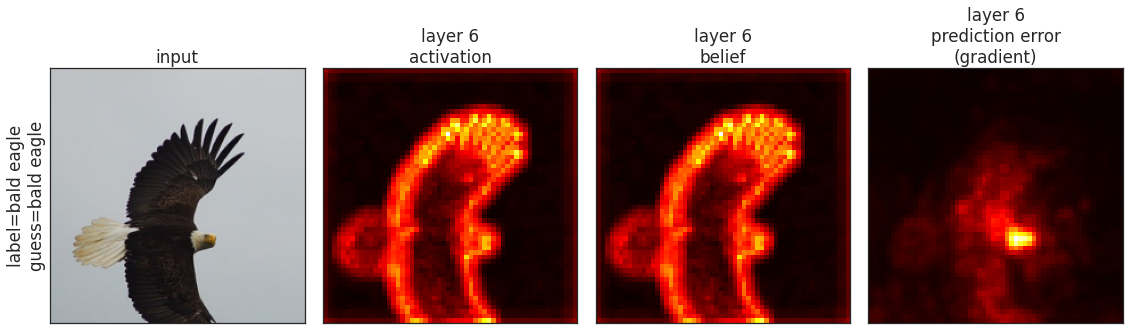

In [2]:
#@title  **Click "show code" if you want to un-collapse the cell and see the code.**

# Code for importing and applying VGG19 adapted from:
# https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_vgg.ipynb


import torch # We no longer import as tch
import torch.nn as nn
import numpy as np
#import torchvision # Contains data sets and functions for image processing
import torchvision.transforms as transforms # Contains MNIST, other image datasets, and image processing functions
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import seaborn as sns
import urllib
from urllib.parse import urlparse
from os.path import splitext, basename

# Import TorchSeq2PC 
!git clone https://github.com/RobertRosenbaum/Torch2PC.git
from Torch2PC import TorchSeq2PC as T2PC

  
# Seed rng
torch.manual_seed(0)

# Define device and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device=',device)

# Download pre-trained model
vgg19 = models.vgg19(pretrained=True)
#vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)

# Download ImageNet labels
# See here for numbered list: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Regroup layers in the model so that each "layer" corresponds to one conv block or
# one dense block
model=nn.Sequential(
        nn.Sequential(vgg19.features[0],vgg19.features[1]),
        nn.Sequential(vgg19.features[2],vgg19.features[3],vgg19.features[4]),        
        nn.Sequential(vgg19.features[5],vgg19.features[6]),        
        nn.Sequential(vgg19.features[7],vgg19.features[8],vgg19.features[9]),
        nn.Sequential(vgg19.features[10],vgg19.features[11]),        
        nn.Sequential(vgg19.features[12],vgg19.features[13]),
        nn.Sequential(vgg19.features[14],vgg19.features[15]), 
        nn.Sequential(vgg19.features[16],vgg19.features[17],vgg19.features[18]),
        nn.Sequential(vgg19.features[19],vgg19.features[20]),
        nn.Sequential(vgg19.features[21],vgg19.features[22]),
        nn.Sequential(vgg19.features[23],vgg19.features[24]),
        nn.Sequential(vgg19.features[25],vgg19.features[26],vgg19.features[27]),
        nn.Sequential(vgg19.features[28],vgg19.features[29]),
        nn.Sequential(vgg19.features[30],vgg19.features[31]),
        nn.Sequential(vgg19.features[32],vgg19.features[33]),
        nn.Sequential(vgg19.features[34],vgg19.features[35],vgg19.features[36]),
        nn.Sequential(vgg19.avgpool,nn.Flatten(),vgg19.classifier[0],vgg19.classifier[1],vgg19.classifier[2]),
        nn.Sequential(vgg19.classifier[3],vgg19.classifier[4],vgg19.classifier[5]),
        vgg19.classifier[6]
).to(device)

#NumParams=sum(p.numel() for p in model.parameters() if p.requires_grad)
#print('Number of trainable parameters in model =',NumParams)
#print('model: ',model)




# Function for pre-processing images for VGG19
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Resize images to get images for plotting
# in a way that will be consistent with
# input images
im_resize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)])



### Download image from url
LocalFileName='MyImage'
_, file_ext = splitext(basename(urlparse(url).path))
try: urllib.URLopener().retrieve(url, LocalFileName+file_ext)
except: urllib.request.urlretrieve(url, LocalFileName+file_ext)
input_image = Image.open(LocalFileName+file_ext)



# Preprocess
input_tensor = preprocess(input_image)
# create a mini-batch of size 1 with shape expected by the model
X = input_tensor.unsqueeze(0) 

# Compute output from model
X=X.to(device)
with torch.no_grad():
  model.eval()
  output = model(X)

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    all_categories = [s.strip() for s in f.readlines()]

# Compute probabilities assigned to all 1000 categories
probabilities = torch.nn.functional.softmax(output, dim=1)

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
top5_prob=top5_prob[0]
top5_catid=top5_catid[0]
print('\nTop-5 probabilities assigned by model:')
for i in range(top5_prob.size(0)):
    print('  ',all_categories[top5_catid[i]]+' ('+str(top5_catid[i].item())+'): ', top5_prob[i].item())

cat_id=top5_catid[0]
category=all_categories[top5_catid[0]]

model.eval()

if label==-1:
  Y=torch.tensor([cat_id])
else:
  Y=torch.tensor([label])

LabelCategory=all_categories[Y[0]]
print('\nBest guess from model: '+category)
print('Label assigned by you: '+LabelCategory)

# Move label to device
Y=Y.to(device)

# Define loss function
LossFun=nn.CrossEntropyLoss()

### Use PCInfer from Torch2PC to perform predictive coding

# Run PC Inference on the model
model.zero_grad()
vhat,Loss,dLdy,v,epsilon=T2PC.PCInfer(model,LossFun,X,Y,ErrType,eta,n)

# Compute prediction errors and activations
Errs=epsilon[layer][0,:,:,:].cpu().detach()
Activations=vhat[layer][0,:,:,:].cpu().detach()
Beliefs=v[layer][0,:,:,:].cpu().detach()

print('\nPixel-averaged norm of prediction errors:',torch.mean(torch.linalg.norm(Errs,ord=2, dim=0)).item())

### Make plot
sns.set(context='notebook',style='white',font_scale=1.4)
fig, axes = plt.subplots(1,4,figsize=(16,6))

plt.subplot(1,4,1)
plt.imshow(im_resize(input_image))
plt.xticks([])
plt.yticks([])
plt.ylabel('label='+LabelCategory+'\nguess='+category)
plt.title('input')


plt.subplot(1,4,2)
plt.imshow(torch.linalg.norm(Activations,ord=2, dim=0),cmap='hot')
plt.xticks([])
plt.yticks([])
plt.title('layer '+str(layer)+'\nactivation')

plt.subplot(1,4,3)
plt.imshow(torch.linalg.norm(Beliefs,ord=2, dim=0),cmap='hot')
plt.xticks([])
plt.yticks([])
plt.title('layer '+str(layer)+'\nbelief')


plt.subplot(1,4,4)
plt.imshow(torch.linalg.norm(Errs,ord=2, dim=0),cmap='hot')
plt.xticks([])
plt.yticks([])
if ErrType=="Exact":
  plt.title('layer '+str(layer)+'\nprediction error\n(gradient)')
else:
  plt.title('layer '+str(layer)+'\nprediction error')

# # Make colorbar
# cb=plt.colorbar(fraction=0.03, pad=.04)
# cb.ax.yaxis.set_offset_position('left')
# cb.formatter.set_powerlimits((0, 0))

plt.tight_layout()

